In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from sklearn.model_selection import GridSearchCV
from IPython.display import display, HTML
from sklearn.feature_selection import f_classif, chi2
from scipy.stats import spearmanr

#XGBoost for feature importance
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

#Deep Learning libraries
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.layers import Bidirectional, InputLayer
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.callbacks import ModelCheckpoint

#Libraries for ARIMA
from statsmodels.tsa.stattools import adfuller
from itertools import cycle
import calendar
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

#Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading CSVs

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/store_sales/train.csv')
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/store_sales/stores.csv')
oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/store_sales/oil.csv')
holidays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/store_sales/holidays_events.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/store_sales/transactions.csv')

In [ ]:
#Corverting date columns to datetime feature
train['date']=pd.to_datetime(train['date'])
holidays['date']=pd.to_datetime(holidays['date'])
transactions['date']=pd.to_datetime(transactions['date'])
oil['date']=pd.to_datetime(oil['date'])

In [ ]:
#Check null function to identify null values
def check_null(df, name):
    print(f"{name} shape:", df.shape)
    print(f"\nNull values in {name} dataframe:")
    null_values = df.isnull().sum()
    null_count = null_values[null_values > 0]
    if null_count.empty:
        print("No null values.")
    else:
        print(null_count)
    print('\n')
# Check shapes and null values of each dataframe

check_null(train, "Train")
check_null(stores, "Stores")
check_null(oil, "Oil")
check_null(holidays, "Holidays")
check_null(transactions, "Transactions")

Train shape: (3000888, 6)

Null values in Train dataframe:
No null values.


Stores shape: (54, 5)

Null values in Stores dataframe:
No null values.


Oil shape: (1218, 2)

Null values in Oil dataframe:
dcoilwtico    43
dtype: int64


Holidays shape: (350, 6)

Null values in Holidays dataframe:
No null values.


Transactions shape: (83488, 3)

Null values in Transactions dataframe:
No null values.




In [ ]:
#Dealing with time discontinuity in the oil.csv
# Set date as index
oil.set_index('date', inplace=True)

# Create a new DataFrame with complete date range
date_range = pd.date_range(start=oil.index.min(), end=oil.index.max(), freq='D')
complete_oil = pd.DataFrame(index=date_range)

# Merge the original oil data with the complete date range DataFrame
complete_oil = complete_oil.merge(oil, left_index=True, right_index=True, how='left')

# Forward fill missing values to carry forward the last known value
complete_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
complete_oil['dcoilwtico'].fillna(method='bfill', inplace=True)#fill the first date

# Reset index
complete_oil.reset_index(inplace=True)
complete_oil.rename(columns={'index': 'date'}, inplace=True)

In [ ]:
# check_null(complete_oil, "Oil")

In [ ]:
#working on holidays dataframe
#the transferred column containing true value signifies that the day was considered as a regular day
#the very next row of each such row shows us the day the holiday was transferred to
#So we take out all the rows containing true values and also

# Dropping rows where 'transferred' column contains 'TRUE'
holidays = holidays[holidays['transferred'] != 'TRUE']

# Replacing values in the 'type' column with 'Holiday'
holidays['type'] = 'Holiday'

# Rename the column 'type' to 'holiday'
holidays.rename(columns={'type': 'holiday'}, inplace=True)

# Set all rows in the 'holiday' column to the value 1
holidays['holiday'] = 1

# Display the updated DataFrame
print(holidays.head())  # Display the first few rows to verify changes

        date  holiday    locale locale_name                    description  \
0 2012-03-02        1     Local       Manta             Fundacion de Manta   
1 2012-04-01        1  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12        1     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14        1     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21        1     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


In [ ]:
# Creating three separate DataFrames based on 'locale'
national_holidays = holidays[holidays['locale'] == 'National']
regional_holidays = holidays[holidays['locale'] == 'Regional']
local_holidays = holidays[holidays['locale'] == 'Local']

In [ ]:
#We Start merging the dataframes

#merging the oil dataframe with train
train = pd.merge(train, complete_oil, on='date', how='left')

#merging the stores dataframe with train
train = pd.merge(train, stores, on='store_nbr', how='left')

#merging the transactions dataframe with train
train = pd.merge(train, transactions, on=['date','store_nbr'], how='left')
print(train.shape)

# Checking columns of each holiday dataframes
column_names_1 = national_holidays.columns.tolist()
print(column_names_1)
column_names_2 = regional_holidays.columns.to_list()
print(column_names_2)
column_names_3 = local_holidays.columns.to_list()
print(column_names_3)

(3000888, 12)
['date', 'holiday', 'locale', 'locale_name', 'description', 'transferred']
['date', 'holiday', 'locale', 'locale_name', 'description', 'transferred']
['date', 'holiday', 'locale', 'locale_name', 'description', 'transferred']


In [ ]:
# dropping duplicate columns: national_holidays
national_holidays.rename(columns={'holiday': 'n_holiday'}, inplace=True)
national_holidays.drop(['locale', 'locale_name', 'description', 'transferred'], inplace=True, axis=1)

# regional_holidays
regional_holidays.rename(columns={'holiday': 'r_holiday'}, inplace=True)
regional_holidays.rename(columns={'locale_name': 'state'}, inplace=True)
regional_holidays.drop(['locale', 'description', 'transferred'], inplace=True, axis=1)

# local_holidays
local_holidays.rename(columns={'holiday': 'l_holiday'}, inplace=True)
local_holidays.rename(columns={'locale_name': 'city'}, inplace=True)
local_holidays.drop(['locale', 'description', 'transferred'], inplace=True, axis=1)

In [ ]:
# Checking for duplicate rows in the holiday dataset
duplicate_rows = national_holidays[national_holidays.duplicated()]
print("Duplicate Rows in 1:")
print(duplicate_rows)

duplicate_rows = regional_holidays[regional_holidays.duplicated()]
print("\nDuplicate Rows in 2:")
print(duplicate_rows)

duplicate_rows = local_holidays[local_holidays.duplicated()]
print("\nDuplicate Rows in 3:")
print(duplicate_rows)

Duplicate Rows in 1:
          date  n_holiday
36  2012-12-24          1
40  2012-12-31          1
157 2014-12-26          1
236 2016-05-01          1
243 2016-05-07          1
245 2016-05-08          1

Duplicate Rows in 2:
Empty DataFrame
Columns: [date, r_holiday, state]
Index: []

Duplicate Rows in 3:
          date  l_holiday       city
265 2016-07-24          1  Guayaquil


In [ ]:
#Dropping duplicate rows from both dataframes
national_holidays.drop_duplicates(inplace=True)
local_holidays.drop_duplicates(inplace=True)

In [ ]:
#Merging the holiday dataframes with training set
train = pd.merge(train, national_holidays, on='date', how='left')
train = pd.merge(train, regional_holidays, on=['date','state'], how='left')
train = pd.merge(train, local_holidays, on=['date','city'], how='left')
print(train.shape)

(3000888, 15)


In [ ]:
# Now we will check for null values and then replace them accordingly
check_null(train, 'Train')

Train shape: (3000888, 15)

Null values in Train dataframe:
transactions     245784
n_holiday       2746062
r_holiday       2999865
l_holiday       2988645
dtype: int64




In [ ]:
# Count rows where 'transaction' is null and 'sales' is 0
count_null_transaction_sales_zero = len(train[(train['transactions'].isnull()) & (train['sales'] == 0)])

# Display the count
print("Count of rows where 'transaction' is null and 'sales' is 0:", count_null_transaction_sales_zero)

Count of rows where 'transaction' is null and 'sales' is 0: 242536


In [ ]:
#As we can see there are 245784 rows in transactions with null values and
#there are 242536 rows where sales are 0 in the 2457854 rows, we will replace
#all null values with zero

columns_to_fill = ['transactions', 'n_holiday', 'r_holiday', 'l_holiday']

# Replace null values with 0 in the specified columns
train[columns_to_fill] = train[columns_to_fill].fillna(0)

# Display the DataFrame after replacing null values with 0
print(train.head())  # Display the first few rows to verify changes

   id       date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0       93.14   
1   1 2013-01-01          1   BABY CARE    0.0            0       93.14   
2   2 2013-01-01          1      BEAUTY    0.0            0       93.14   
3   3 2013-01-01          1   BEVERAGES    0.0            0       93.14   
4   4 2013-01-01          1       BOOKS    0.0            0       93.14   

    city      state type  cluster  transactions  n_holiday  r_holiday  \
0  Quito  Pichincha    D       13           0.0        1.0        0.0   
1  Quito  Pichincha    D       13           0.0        1.0        0.0   
2  Quito  Pichincha    D       13           0.0        1.0        0.0   
3  Quito  Pichincha    D       13           0.0        1.0        0.0   
4  Quito  Pichincha    D       13           0.0        1.0        0.0   

   l_holiday  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  


In [ ]:
# Modify values based on specified conditions
train.loc[train['n_holiday'] == 1, ['r_holiday', 'l_holiday']] = 1
train.loc[train['r_holiday'] == 1, 'l_holiday'] = 1

In [ ]:
#Checking unique values in the columns to deal with each feature accordingly
print(train.shape)
check_null(train, "Train")
print("\nTrain df:")
display(HTML(train.head(10).to_html()))

(3000888, 15)
Train shape: (3000888, 15)

Null values in Train dataframe:
No null values.



Train df:


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions,n_holiday,r_holiday,l_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
6,6,2013-01-01,1,CELEBRATION,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
7,7,2013-01-01,1,CLEANING,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
8,8,2013-01-01,1,DAIRY,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0
9,9,2013-01-01,1,DELI,0.0,0,93.14,Quito,Pichincha,D,13,0.0,1.0,1.0,1.0


In [ ]:
#We will do one hot encoding of each categorial variable

# Create a deep copy of 'train'
train_copy = train.copy(deep=True)
columns_to_encode = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster']
train_encoded = pd.get_dummies(train_copy, columns=columns_to_encode, drop_first=True)

#Checking Shape
train_encoded.shape

(3000888, 150)

In [ ]:
# Add date, month, year as features
train_encoded['day'] = train_encoded['date'].dt.day
train_encoded['month'] = train_encoded['date'].dt.month
train_encoded['year'] = train_encoded['date'].dt.year

# Add weekdays as one hot encoded features
train_encoded['weekday'] = train_encoded['date'].dt.day_name()
one_hot_encoding = OneHotEncoder(sparse=False, dtype=int)
weekday_encoded = one_hot_encoding.fit_transform(train_encoded[['weekday']])
weekday_columns = one_hot_encoding.get_feature_names_out(['weekday'])
weekday_df = pd.DataFrame(weekday_encoded, columns=weekday_columns, index=train_encoded.index)
train_encoded = pd.concat([train_encoded, weekday_df], axis=1)

# Drop the original 'family' column
train_encoded.drop('weekday', axis=1, inplace=True)

#Checking Shape
print(train_encoded.shape)

display(HTML(train_encoded.head(10).to_html()))

(3000888, 160)


,id,date,sales,onpromotion,dcoilwtico,transactions,n_holiday,r_holiday,l_holiday,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_B,type_C,type_D,type_E,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,day,month,year,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2013,0,0,0,0,0,1,0
1,1,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2013,0,0,0,0,0,1,0
2,2,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2013,0,0,0,0,0,1,0
3,3,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2013,0,0,0,0,0,1,0
4,4,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2013,0,0,0,0,0,1,0
5,5,2013-01-01,0.0,0,93.14,0.0,1.0,1.0,1.0,0,0,0,

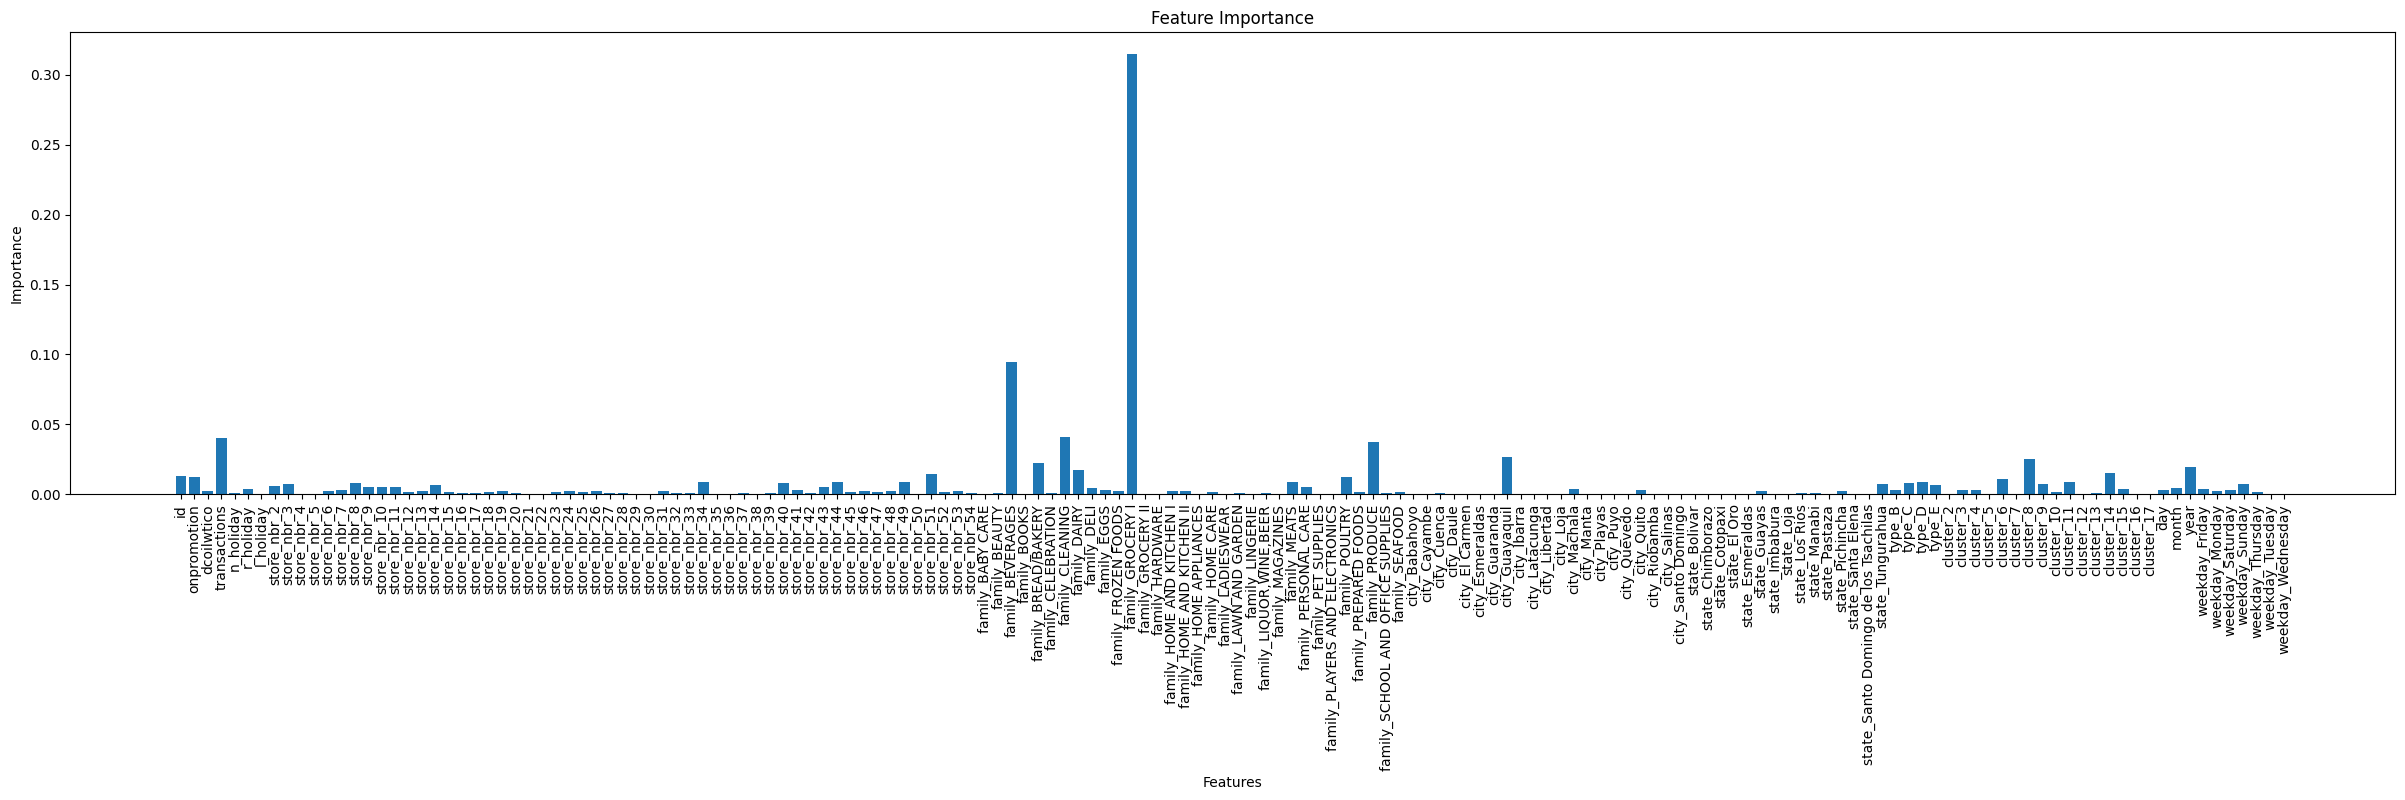

In [ ]:
#Using XGBoost for finding feature importance
# Spliting data into training and testing sets
X = train_encoded.drop(['sales','date'], axis=1)
y = train_encoded['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize XGBoost regressor
model = XGBRegressor()

# Fit the model
model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(30,6))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), X.columns, rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
#We can easily drop the city and state columns as they show least importance

columns_to_drop = train_encoded.filter(regex='^city|^state').columns
sales_all = train_encoded.drop(columns=columns_to_drop)

print(sales_all.shape)

(3000888, 124)


In [ ]:
#We can also take the overall sales data of all the stores per day
# Create a deep copy of 'train'
train_copy3 = train.copy(deep=True)

columns_to_drop = ['store_nbr', 'id', 'type', 'family', 'cluster','state', 'city', 'cluster']
train_copy3 = train_copy3.drop(columns=columns_to_drop)

exclude_columns = ['date']
columns_to_aggregate = train_copy3.columns.difference(exclude_columns)

# Group by 'date' and 'family' columns
sales_daily = train_copy3.groupby(['date'])[columns_to_aggregate].mean().reset_index()

In [ ]:
#Extracting Date Time features and One hot Encoding the Family column
sales_daily['day'] = sales_daily['date'].dt.day
sales_daily['month'] = sales_daily['date'].dt.month
sales_daily['year'] = sales_daily['date'].dt.year

# Add weekdays as one hot encoded features
sales_daily['weekday'] = sales_daily['date'].dt.day_name()
one_hot_encoding = OneHotEncoder(sparse=False, dtype=int)
weekday_encoded = one_hot_encoding.fit_transform(sales_daily[['weekday']])
weekday_columns = one_hot_encoding.get_feature_names_out(['weekday'])
weekday_df = pd.DataFrame(weekday_encoded, columns=weekday_columns, index=sales_daily.index)
sales_daily = pd.concat([sales_daily, weekday_df], axis=1)
sales_daily.drop('weekday', axis=1, inplace=True)


#We will set back all the values in holiday columns back to 1
columns_to_replace = ['l_holiday', 'n_holiday', 'r_holiday']
sales_daily[columns_to_replace] = sales_daily[columns_to_replace].applymap(lambda x: 1 if x > 0 else x)

In [ ]:
#XGBoost model forecasting
# Split the data into train and test sets
train_data, test_data = train_test_split(sales_all, test_size=0.2, random_state=42, shuffle=True)

# Define the features and target variable
X_train = train_data.drop(['date', 'sales'], axis=1)
y_train = train_data['sales']
X_test = test_data.drop(['date', 'sales'], axis=1)
y_test = test_data['sales']

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the XGBoost model
model_xg = XGBRegressor(
    n_estimators=10,
    max_depth=4,
    min_child_weight=1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'  #using histogram based algorithm
)

model_xg.fit(X_train, y_train)
predictions_xg = model_xg.predict(X_test+1)


rmsle_xg = np.sqrt(mean_squared_log_error(y_test, predictions_xg))
print(rmsle_xg)


6.72736349933544


In [ ]:
#Feedback edition: Using Time Series split by forward chaining CV
#XGBoost Using Time series split
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 18, test_size=1782*30, gap=1782)
sales_all = sales_all.sort_index()

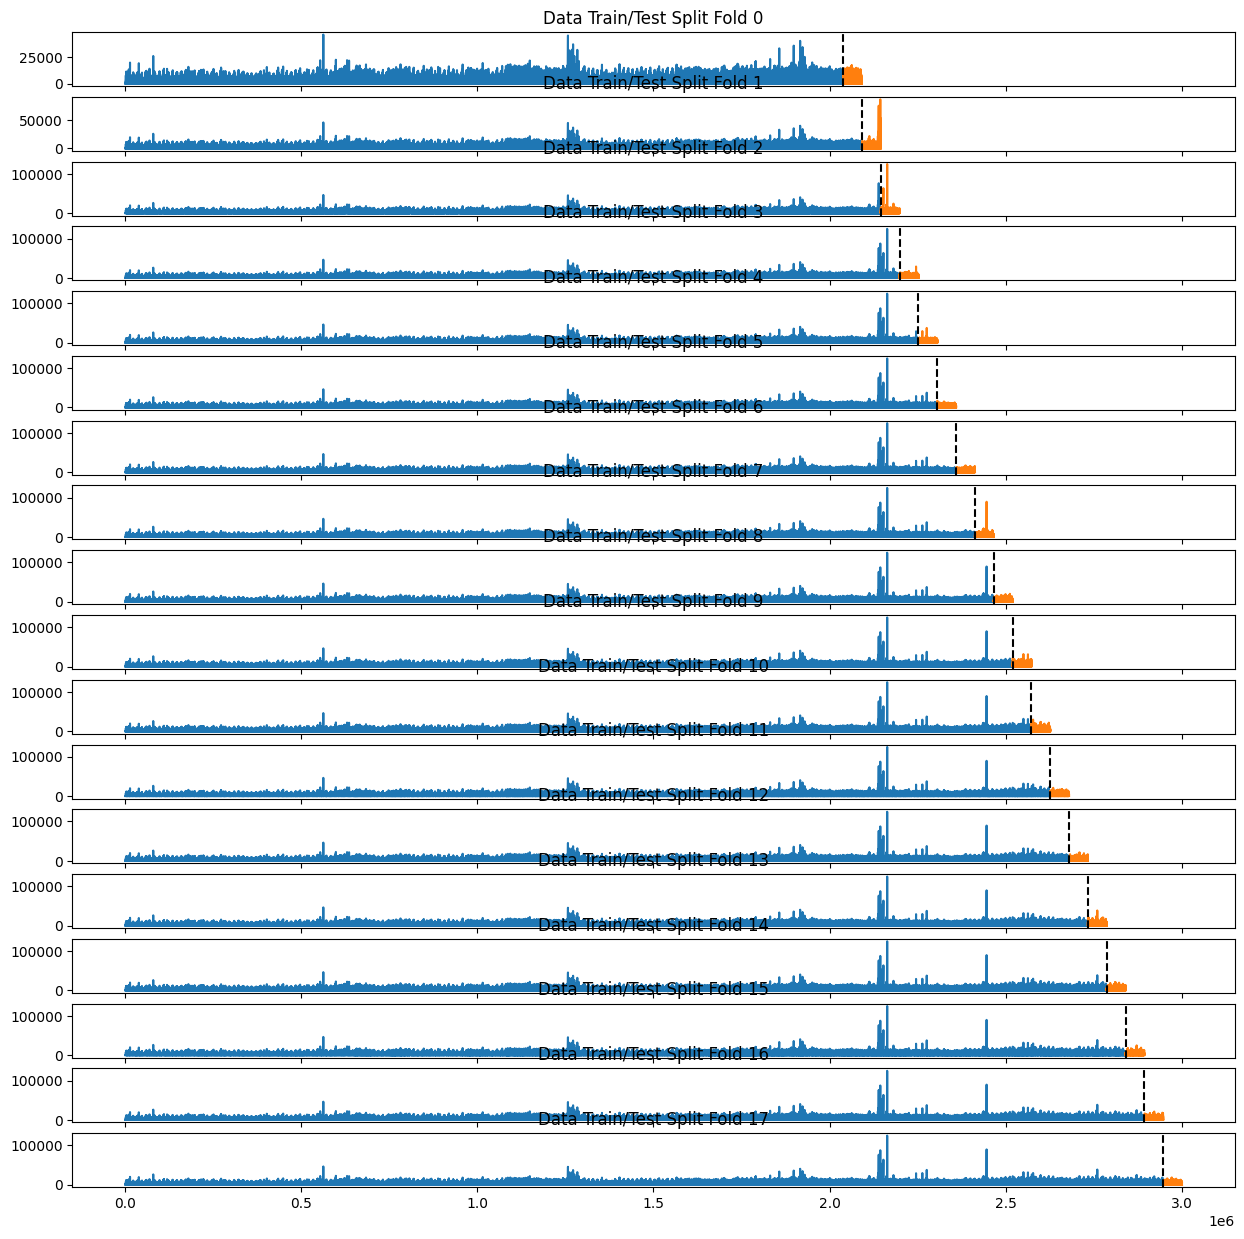

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(18, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(sales_all):
    train = sales_all.iloc[train_idx]
    test = sales_all.iloc[val_idx]
    train['sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['sales'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# for train_idx, val_idx in tss.split(sales_all):
#   break

In [ ]:
import pandas as pd

def add_lags(sales_all):
    # Ensure the index is in datetime format
    sales_all.index = pd.to_datetime(sales_all.index)

    # Create a target map using 'sales' column to map values for lags
    target_map = sales_all['sales'].to_dict()

    # Calculate lags using timedelta and map the values based on index
    sales_all['lag1'] = (sales_all.index - pd.Timedelta(days=364)).map(target_map)
    sales_all['lag2'] = (sales_all.index - pd.Timedelta(days=728)).map(target_map)
    sales_all['lag3'] = (sales_all.index - pd.Timedelta(days=1092)).map(target_map)

    return sales_all

# # Assuming 'sales_all' is your DataFrame
# sales_all = add_lags(sales_all)


In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(sales_all):
    train = sales_all.iloc[train_idx]
    test = sales_all.iloc[val_idx]

    FEATURES = sales_all.drop(['date', 'sales'], axis=1)
    TARGET = sales_all['sales']

    X_train = train.drop(['date', 'sales'], axis=1)
    y_train = train['sales']

    X_test = test.drop(['date', 'sales'], axis=1)
    y_test = test['sales']

    # # Scale the features
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # Define the XGBoost model
    model_xg = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    min_child_weight=5,
    learning_rate=0.01,
    subsample=1.0,
    colsample_bytree=0.8,
    tree_method='hist'  #using histogram based algorithm
    )

    model_xg.fit(X_train, y_train)
    predictions_xg = model_xg.predict(X_test)


    rmsle_xg = np.sqrt(mean_squared_log_error(y_test, predictions_xg))
    print(rmsle_xg)
    preds.append(predictions_xg)
    score = np.sqrt(mean_squared_log_error(y_test, predictions_xg))
    scores.append(score)

3.029944498215775
3.0472438410271634
3.0185499233531887
3.064330041754954
3.0747084924745827
3.0636347078490918
3.1136139180575557
3.1501062562860107
3.1124205428191014
3.0542572290053926
3.064247258398848
2.996625400123635
2.994907799229582
2.9807702959236413
2.897236116895582
2.925653362262165
2.9286843740041117
2.931807311240563


In [ ]:
final_score = scores[-1]  # Get the last score in the list
print(f'Final score: {final_score:0.4f}')
print(f'Fold scores: {scores}')

Final score: 2.9318
Fold scores: [3.029944498215775, 3.0472438410271634, 3.0185499233531887, 3.064330041754954, 3.0747084924745827, 3.0636347078490918, 3.1136139180575557, 3.1501062562860107, 3.1124205428191014, 3.0542572290053926, 3.064247258398848, 2.996625400123635, 2.994907799229582, 2.9807702959236413, 2.897236116895582, 2.925653362262165, 2.9286843740041117, 2.931807311240563]


In [ ]:
#Multivariate Time series forecasting using LSTM
X = sales_all.drop(['date', 'sales'], axis=1)
y = sales_all['sales'].values.reshape(-1, 1)  # Reshaping to a 2D array

# Normalizing features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#Setting time_steps
time_steps = 30
target_length = 1

num_features = X.shape[1]
num_samples = len(X) // time_steps

X_tensor = X_scaled[:num_samples * time_steps]
X_tensor = X_tensor.reshape(num_samples, time_steps, num_features)

# Trim target variable to fit the shape of X_tensor
y_tensor = y[:num_samples * time_steps]
y_tensor = y_tensor.reshape(num_samples, time_steps, 1)

# Trim to predict the next 1 row
X_predict = X_scaled[-target_length:]
X_predict = X_predict.reshape(1, target_length, num_features)

# Verify tensor shapes
print(f"X_tensor shape: {X_tensor.shape}")
print(f"y_tensor shape: {y_tensor.shape}")
print(f"X_predict shape: {X_predict.shape}")

X_tensor shape: (100029, 30, 122)
y_tensor shape: (100029, 30, 1)
X_predict shape: (1, 1, 122)


In [ ]:
# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(X_tensor))
val_size = int(0.2 * len(X_tensor))
test_size = len(X_tensor) - train_size - val_size

X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
X_val, y_val = X_tensor[train_size:train_size + val_size], y_tensor[train_size:train_size + val_size]
X_test, y_test = X_tensor[-test_size:], y_tensor[-test_size:]

# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape=(time_steps, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True, activation='tanh'))
model.add(Dense(units=32))
model.add(Dense(units=target_length))

#Defining rmsle function
def rmsle(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)), axis=-1))

# Defining a learning rate schedule function
def scheduler(epoch, lr):
    return lr * math.exp(-0.1)

# Defining the optimizer
optimizer = Adam(learning_rate=0.0001)

# Compiling the model

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmsle])

# Train the LSTM model
lr_scheduler = LearningRateScheduler(scheduler)
history = model.fit(X_train, y_train, epochs=20, callbacks=[lr_scheduler], batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/20
2189/2189 [==============================] - 36s 11ms/step - loss: 1014666.9375 - rmsle: 2.8809 - val_loss: 1807308.1250 - val_rmsle: 2.7000 - lr: 9.0484e-05
Epoch 2/20
2189/2189 [==============================] - 22s 10ms/step - loss: 945957.2500 - rmsle: 2.9582 - val_loss: 1651024.0000 - val_rmsle: 1.9829 - lr: 8.1873e-05
Epoch 3/20
2189/2189 [==============================] - 21s 10ms/step - loss: 784307.3125 - rmsle: 1.8372 - val_loss: 1391007.3750 - val_rmsle: 1.6338 - lr: 7.4082e-05
Epoch 4/20
2189/2189 [==============================] - 21s 10ms/step - loss: 641488.3125 - rmsle: 1.6350 - val_loss: 1181298.6250 - val_rmsle: 1.3140 - lr: 6.7032e-05
Epoch 5/20
2189/2189 [==============================] - 21s 10ms/step - loss: 533373.9375 - rmsle: 1.5076 - val_loss: 1018245.3125 - val_rmsle: 1.1756 - lr: 6.0653e-05
Epoch 6/20
2189/2189 [==============================] - 21s 10ms/step - loss: 450075.8125 - rmsle: 1.4349 - val_loss: 886396.4375 - val_rmsle: 1.1261 - lr: 5.4

In [ ]:
#Feedback edition: Using Time Series split by forward chaining CV

# Define a learning rate schedule function
def scheduler(epoch, lr):
    return lr * math.exp(-0.1)

# Defining rmsle function
def rmsle(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)), axis=-1))



num_parts = 18  # Define the number of parts to split your dataset into
part_size = len(sales_all) // num_parts
combined_data = []

for i in range(num_parts):
    start_idx = i * part_size
    end_idx = start_idx + part_size if i < num_parts - 1 else len(sales_all)
    current_part = sales_all.iloc[start_idx:end_idx]

    X = current_part.drop(['date', 'sales'], axis=1)  # Excluding 'date' and 'sales' columns
    y = current_part['sales'].values.reshape(-1, 1)  # Reshaping to a 2D array

    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert data to 3D tensor shape (samples, time steps, features)
    time_steps = 30
    target_length = 1
    num_features = X.shape[1]
    num_samples = len(X) // time_steps

    X_tensor = X_scaled[:num_samples * time_steps]
    X_tensor = X_tensor.reshape(num_samples, time_steps, num_features)

    y_tensor = y[:num_samples * time_steps]
    y_tensor = y_tensor.reshape(num_samples, time_steps, 1)

    X_predict = X_scaled[-target_length:]
    X_predict = X_predict.reshape(1, target_length, num_features)

    train_size = int(0.7 * len(X_tensor))
    val_size = int(0.2 * len(X_tensor))
    test_size = len(X_tensor) - train_size - val_size

    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_val, y_val = X_tensor[train_size:train_size + val_size], y_tensor[train_size:train_size + val_size]
    X_test, y_test = X_tensor[-test_size:], y_tensor[-test_size:]

    # Define the LSTM model
    # Define the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(time_steps, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True, activation='tanh'))
    model.add(Dense(units=32))
    model.add(Dense(units=target_length))
    # Define the optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmsle])

    # Train the LSTM model
    lr_scheduler = LearningRateScheduler(scheduler)
    history = model.fit(X_train, y_train, epochs=20, callbacks=[lr_scheduler], batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    combined_data.append(current_part)

Epoch 1/20
122/122 [==============================] - 7s 20ms/step - loss: 460808.7500 - rmsle: 2.8105 - val_loss: 457204.0625 - val_rmsle: 3.2046 - lr: 9.0484e-04
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 441339.2188 - rmsle: 3.4274 - val_loss: 445300.8750 - val_rmsle: 3.0477 - lr: 8.1873e-04
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 436803.8125 - rmsle: 3.1999 - val_loss: 443449.9062 - val_rmsle: 3.2126 - lr: 7.4082e-04
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 432186.1562 - rmsle: 3.3495 - val_loss: 439795.1875 - val_rmsle: 3.2600 - lr: 6.7032e-04
Epoch 5/20
122/122 [==============================] - 1s 10ms/step - loss: 417972.1562 - rmsle: 3.0209 - val_loss: 402900.7812 - val_rmsle: 2.5965 - lr: 6.0653e-04
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 379202.7500 - rmsle: 2.6906 - val_loss: 363729.0312 - val_rmsle: 2.4592 - lr: 5.4881e-04
Epoch 7/20
122/1

In [ ]:
#Multivariate forecasting with GRU
#Applying the same model on sales_daily dataset

# Defineing the GRU model
model = Sequential()
model.add(GRU(units=64,  return_sequences=True, input_shape=(time_steps, num_features)))
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(GRU(units=32, return_sequences=True, activation='tanh'))
model.add(Dense(units=1))



def rmsle(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)), axis=-1))


def scheduler(epoch, lr):
    return lr * math.exp(-0.1)

# Defining the optimizer
optimizer = SGD(learning_rate=0.001)

# Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmsle])

# Training the LSTM model
lr_scheduler = LearningRateScheduler(scheduler)
history = model.fit(X_train, y_train, epochs=20, callbacks=[lr_scheduler], batch_size=32, validation_data=(X_val, y_val))

# Evaluating the model on test data
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/20
122/122 [==============================] - 5s 13ms/step - loss: 1848332.6250 - rmsle: 2.9017 - val_loss: 1703735.1250 - val_rmsle: 2.9955 - lr: 9.0484e-04
Epoch 2/20
122/122 [==============================] - 1s 7ms/step - loss: 1827804.2500 - rmsle: 3.0022 - val_loss: 1703722.2500 - val_rmsle: 3.0043 - lr: 8.1873e-04
Epoch 3/20
122/122 [==============================] - 1s 7ms/step - loss: 1827711.0000 - rmsle: 3.0065 - val_loss: 1703794.7500 - val_rmsle: 2.9890 - lr: 7.4082e-04
Epoch 4/20
122/122 [==============================] - 1s 8ms/step - loss: 1827783.3750 - rmsle: 3.0010 - val_loss: 1703721.1250 - val_rmsle: 3.0044 - lr: 6.7032e-04
Epoch 5/20
122/122 [==============================] - 1s 8ms/step - loss: 1827713.7500 - rmsle: 3.0026 - val_loss: 1703750.5000 - val_rmsle: 3.0088 - lr: 6.0653e-04
Epoch 6/20
122/122 [==============================] - 1s 8ms/step - loss: 1827755.0000 - rmsle: 3.0040 - val_loss: 1703719.5000 - val_rmsle: 3.0042 - lr: 5.4881e-04
Epoch 7/2

In [ ]:
#Univariate Forecasting using Arima

In [ ]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month

# Group by 'year' and 'month' and calculate the total sales for each group
monthly_sales = train.groupby(['month', 'year'], as_index=False)['sales'].mean()

# Group by date and calculate the total mean sales for each group
daily_sales = train.groupby(['date'], as_index=False)['sales'].mean()

# Display the result
print(monthly_sales.shape)
print(daily_sales.shape)

(55, 3)
(1653, 2)


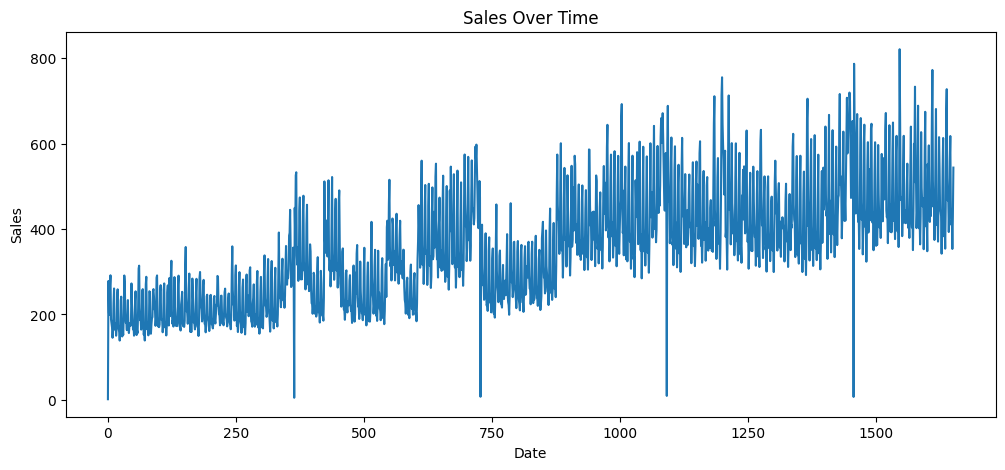

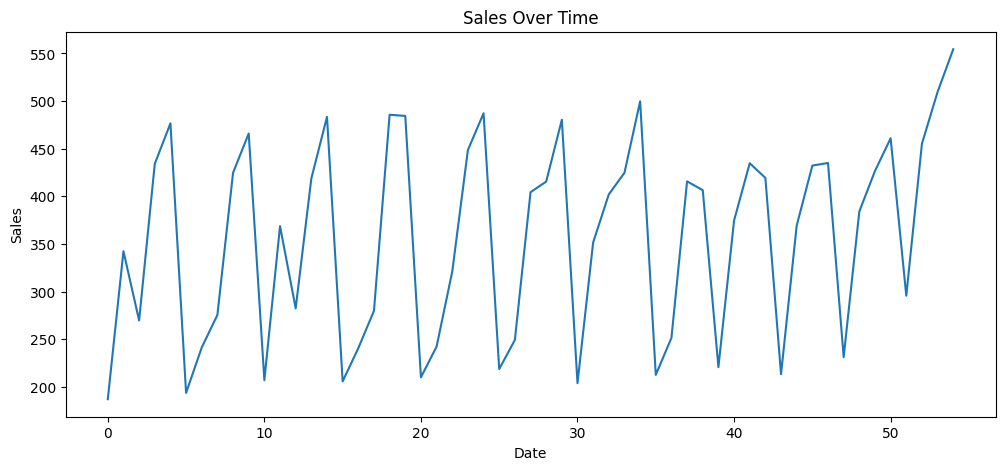

In [ ]:
# Plot the sales data
daily_sales['sales'].plot(figsize=(12, 5), title='Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

monthly_sales['sales'].plot(figsize=(12, 5), title='Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
#Using sales mean
sales_column = daily_sales['sales']

# As per the chart the data is not stationary
#Trying ADFULLER again to check stationarity issue
result = adfuller(sales_column)
print("1. ADF : ", result[0])
print("2. P-VALUE : ", result[1])
print("3. Num of Lags : ", result[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculation : ", result[3])
print("5. Critical Values : ")
for key, val in result[4].items():
    print("\t",key, ": ",val)
# Check if p-value is less than your significance level
if result[1] <= 0.05:
    print('Time series is likely stationary.')
else:
    print('Time series is likely not stationary. Trying differencing or other methods.')

1. ADF :  -2.5529238089141524
2. P-VALUE :  0.10312243474646471
3. Num of Lags :  22
4. Num of Observations used for ADF Regression and Critical Values Calculation :  1630
5. Critical Values : 
	 1% :  -3.4343681767217062
	 5% :  -2.863314793016078
	 10% :  -2.5677148609281493
Time series is likely not stationary. Trying differencing or other methods.


In [ ]:
#Trying ADFULLER again to check stationarity issue

from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_sales['sales'].diff()[1:])
print("1. ADF : ", result[0])
print("2. P-VALUE : ", result[1])
print("3. Num of Lags : ", result[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculation : ", result[3])
print("5. Critical Values : ")
for key, val in result[4].items():
    print("\t",key, ": ",val)
# Check if p-value is less than your significance level
if result[1] <= 0.05:
    print('Time series is likely stationary.')
else:
    print('Time series is likely not stationary. Trying differencing or other methods.')

# We can conclude that, the stationarity technique worked as the P-VALUE is far less that "0.05" and we have a stationary data.

1. ADF :  -11.320701261121565
2. P-VALUE :  1.1761424733087952e-20
3. Num of Lags :  25
4. Num of Observations used for ADF Regression and Critical Values Calculation :  1626
5. Critical Values : 
	 1% :  -3.434378077206262
	 5% :  -2.8633191630261203
	 10% :  -2.5677171879165286
Time series is likely stationary.


In [ ]:
#Daily Sales copy
daily_sales_copy = daily_sales.copy(deep=True)

# Create a column for differences in sales
daily_sales['sales_diff'] = daily_sales['sales'].diff()

# Replace the first value of 'sales_diff' with the first value of 'sales'
daily_sales.at[0, 'sales_diff'] = daily_sales['sales'].iloc[0]

# Drop the original 'sales' column
daily_sales.drop(columns=['sales'], inplace=True)

# Rename 'sales_diff' to 'sales'
daily_sales.rename(columns={'sales_diff': 'sales'}, inplace=True)

# FINDING THE ORDER FOR ARIMA MODEL
step_arima = auto_arima(daily_sales['sales'], trace=True)

step_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18901.521, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19568.430, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19563.834, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19392.241, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19566.452, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=18939.083, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18918.747, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18914.527, Time=1.21 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=18887.733, Time=1.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=18936.486, Time=1.14 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=18578.377, Time=1.84 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=18336.037, Time=1.80 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=18395.330, Time=1.75 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=18304.724, Time=2.15 sec
 ARIMA(5,0,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1653
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -9018.445
Date:                Thu, 07 Dec 2023   AIC                          18060.890
Time:                        04:40:15   BIC                          18125.814
Sample:                             0   HQIC                         18084.959
                               - 1653                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4145      0.324      1.278      0.201      -0.221       1.050
ar.L1          1.1781      0.026     45.749      0.000       1.128       1.229
ar.L2         -1.7417      0.022    -77.747      0.000      -1.786      -1.698
ar.L3          1.3492      0.037     36.799      0.000       1.277       1.421
ar.L4         -1.2949      0.021    -62.536      0.000      -1.335      -1.254
ar.L5          0.3815      0.025     15.479      0.000       0.333       0.430
ma.L1         -1.6793      0.025    -67.353      0.000      -1.728      -1.630
ma.L2          2.0171      0.034     59.039      0.000       1.950       2.084
ma.L3         -1.8749      0.038    -49.341      0.000      -1.949      -1.800
ma.L4          1.4371      0.031     46.705      0.000       1.377       1.497
ma.L5         -0.7485      0.020    -37.113      0.000      -0.788      -0.709
sigma2      3912.6816     74.059     52.832      0.000    3767.529    4057.834
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):             40177.22
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.88   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from IPython.display import display, HTML
print(daily_sales.shape)

daily_sales_train=daily_sales.iloc[:-33]
daily_sales_test=daily_sales.iloc[-33:]

print (daily_sales_train.shape, daily_sales_test.shape)

display(HTML(daily_sales.head(10).to_html()))

(1653, 2)
(1620, 2) (33, 2)


,date,sales
0,2013-01-01,1.409438
1,2013-01-02,276.981369
2,2013-01-03,-75.550610
3,2013-01-04,-3.929043
4,2013-01-05,68.962090
5,2013-01-06,23.762783
6,2013-01-07,-103.014927
7,2013-01-08,-9.974760
8,2013-01-09,-8.875965
9,2013-01-10,-24.438163


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display, HTML

print(daily_sales_train.shape)
display(HTML(daily_sales_train.head(10).to_html()))

# Fit ARIMA model
model = ARIMA(daily_sales_train['sales'], order=(5, 0, 5))
model = model.fit()
print(model.summary())

(1620, 2)


,date,sales
0,2013-01-01,1.409438
1,2013-01-02,276.981369
2,2013-01-03,-75.550610
3,2013-01-04,-3.929043
4,2013-01-05,68.962090
5,2013-01-06,23.762783
6,2013-01-07,-103.014927
7,2013-01-08,-9.974760
8,2013-01-09,-8.875965
9,2013-01-10,-24.438163


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1620
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -8843.232
Date:                Thu, 07 Dec 2023   AIC                          17710.464
Time:                        04:41:34   BIC                          17775.147
Sample:                             0   HQIC                         17734.468
                               - 1620                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2517      0.299      0.841      0.400      -0.335       0.838
ar.L1          1.0956      0.025     43.755      0.000       1.047       1.145
ar.L2         -1.6722      0.021    -78.840      0.0

In [ ]:
start = len(daily_sales_train)
end = len(daily_sales_train)+len(daily_sales_test)-1
pred = model.predict(start=start,end=end, type='levels')
print(pred)
pred.index=daily_sales.index[start:end+1]
print(pred)

1620     -9.703818
1621     26.334779
1622    -33.130307
1623     48.542613
1624    149.362096
1625      6.713848
1626   -133.624266
1627    -43.941094
1628     14.648536
1629    -36.750961
1630     48.346954
1631    146.008103
1632      2.852895
1633   -131.598326
1634    -40.247871
1635     14.641780
1636    -36.715445
1637     49.252718
1638    143.001251
1639     -0.774748
1640   -129.479066
1641    -36.655625
1642     14.563754
1643    -36.655974
1644     50.136326
1645    139.995565
1646     -4.277717
1647   -127.303667
1648    -33.174287
1649     14.415143
1650    -36.572755
1651     50.996808
1652    136.992038
Name: predicted_mean, dtype: float64
1620     -9.703818
1621     26.334779
1622    -33.130307
1623     48.542613
1624    149.362096
1625      6.713848
1626   -133.624266
1627    -43.941094
1628     14.648536
1629    -36.750961
1630     48.346954
1631    146.008103
1632      2.852895
1633   -131.598326
1634    -40.247871
1635     14.641780
1636    -36.715445
1637     49.2

In [ ]:
from math import sqrt
rmse=sqrt(mean_squared_error(pred,daily_sales_test['sales']))
print(rmse)

41.529273837218575


In [ ]:
#Feedback edition: Running ARIMA on the dataset without differencing i.e.
#checking stationarity of the sales vales

# FINDING THE ORDER FOR ARIMA MODEL
step_arima = auto_arima(daily_sales_copy['sales'], trace=True)

step_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18908.181, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19557.594, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19552.985, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19376.732, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19555.616, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18928.225, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18907.794, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19083.595, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19302.104, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18909.775, Time=0.71 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19281.899, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18903.701, Time=1.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=18381.282, Time=1.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18788.053, Time=1.15 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1653
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9015.907
Date:                Thu, 07 Dec 2023   AIC                          18055.814
Time:                        04:44:16   BIC                          18120.731
Sample:                             0   HQIC                         18079.881
                               - 1653                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4140      0.394      1.052      0.293      -0.357       1.185
ar.L1          1.1039      0.028     40.071      0.000       1.050       1.158
ar.L2         -1.6823      0.024    -69.385      0.000      -1.730      -1.635
ar.L3          1.2457      0.039     32.023      0.000       1.169       1.322
ar.L4         -1.2370      0.023    -54.325      0.000      -1.282      -1.192
ar.L5          0.3141      0.027     11.791      0.000       0.262       0.366
ma.L1         -1.6251      0.026    -62.725      0.000      -1.676      -1.574
ma.L2          1.9782      0.035     56.262      0.000       1.909       2.047
ma.L3         -1.8255      0.040    -46.142      0.000      -1.903      -1.748
ma.L4          1.4188      0.031     45.664      0.000       1.358       1.480
ma.L5         -0.7580      0.021    -36.067      0.000      -0.799      -0.717
sigma2      3929.7159     71.130     55.247      0.000    3790.303    4069.128
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42456.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from IPython.display import display, HTML
print(daily_sales.shape)

daily_sales_train=daily_sales.iloc[:-33]
daily_sales_test=daily_sales.iloc[-33:]

print (daily_sales_train.shape, daily_sales_test.shape)

display(HTML(daily_sales.head(10).to_html()))


(1653, 2)
(1620, 2) (33, 2)


,date,sales
0,2013-01-01,1.409438
1,2013-01-02,276.981369
2,2013-01-03,-75.550610
3,2013-01-04,-3.929043
4,2013-01-05,68.962090
5,2013-01-06,23.762783
6,2013-01-07,-103.014927
7,2013-01-08,-9.974760
8,2013-01-09,-8.875965
9,2013-01-10,-24.438163


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display, HTML

print(daily_sales_train.shape)
display(HTML(daily_sales_train.head(10).to_html()))

# Fit ARIMA model
model = ARIMA(daily_sales_train['sales'], order=(5, 1, 5)) ####
model = model.fit()
print(model.summary())

(1620, 2)


,date,sales
0,2013-01-01,1.409438
1,2013-01-02,276.981369
2,2013-01-03,-75.550610
3,2013-01-04,-3.929043
4,2013-01-05,68.962090
5,2013-01-06,23.762783
6,2013-01-07,-103.014927
7,2013-01-08,-9.974760
8,2013-01-09,-8.875965
9,2013-01-10,-24.438163


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1620
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -8975.336
Date:                Thu, 07 Dec 2023   AIC                          17972.671
Time:                        04:45:17   BIC                          18031.957
Sample:                             0   HQIC                         17994.673
                               - 1620                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3885      0.029     13.185      0.000       0.331       0.446
ar.L2         -1.1112      0.023    -47.889      0.000      -1.157      -1.066
ar.L3          0.2112      0.042      5.047      0.0

In [ ]:
start = len(daily_sales_train)
end = len(daily_sales_train)+len(daily_sales_test)-1
pred = model.predict(start=start,end=end, type='levels')
print(pred)
pred.index=daily_sales.index[start:end+1]
print(pred)

1620    -33.580204
1621     18.620730
1622    -25.742334
1623     37.834462
1624    171.609270
1625     20.710782
1626   -164.725514
1627    -65.254611
1628     32.354262
1629    -33.020657
1630     39.375403
1631    169.718052
1632     20.432892
1633   -163.129104
1634    -62.794645
1635     32.113962
1636    -34.555693
1637     38.612181
1638    168.783979
1639     19.754112
1640   -161.392765
1641    -60.429008
1642     31.894465
1643    -36.069700
1644     37.883639
1645    167.850515
1646     19.065936
1647   -159.675936
1648    -58.092101
1649     31.668996
1650    -37.552192
1651     37.184763
1652    166.919422
Name: predicted_mean, dtype: float64
1620    -33.580204
1621     18.620730
1622    -25.742334
1623     37.834462
1624    171.609270
1625     20.710782
1626   -164.725514
1627    -65.254611
1628     32.354262
1629    -33.020657
1630     39.375403
1631    169.718052
1632     20.432892
1633   -163.129104
1634    -62.794645
1635     32.113962
1636    -34.555693
1637     38.6

In [ ]:
from math import sqrt
rmse=sqrt(mean_squared_error(pred,daily_sales_test['sales']))
print(rmse)

43.51390696231211
